# Sales Forecasting

This Scipt will enable the Sales Managers to predict the sales for future time period and display the results based off various ML algorithms. 

## Imporint Libraries

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import re
import math
import datetime
import calendar
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

## Import Data from file

In [2]:
# fetch data from CSV to DataFrame

sales = pd.read_csv('Sales_Forecasting.csv')

## Data analysis and Manipulation

In [3]:
# Convert sales headers to lowercase

sales.columns = map(str.lower, sales.columns)
sales.head()

,regions,date,channel,product,sales
0,Africa,1/1/2024,Distributor,Support,"5,688.00"
1,Africa,1/2/2024,Distributor,Certification,"2,528.00"
2,Africa,1/3/2024,Distributor,MIS,"5,676.00"
3,Africa,1/4/2024,Distributor,ERP,"7,179.00"
4,Africa,1/5/2024,Distributor,OTHERS,"1,001.00"


In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35230 entries, 0 to 35229
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   regions  35230 non-null  object
 1   date     35230 non-null  object
 2   channel  35230 non-null  object
 3   product  35230 non-null  object
 4   sales    35230 non-null  object
dtypes: object(5)
memory usage: 1.3+ MB


In [5]:
# convert sales amount to numeric

sales['sales'] = sales['sales'].str.replace(',', '').astype(float)
sales['sales'] = pd.to_numeric(sales['sales']) 


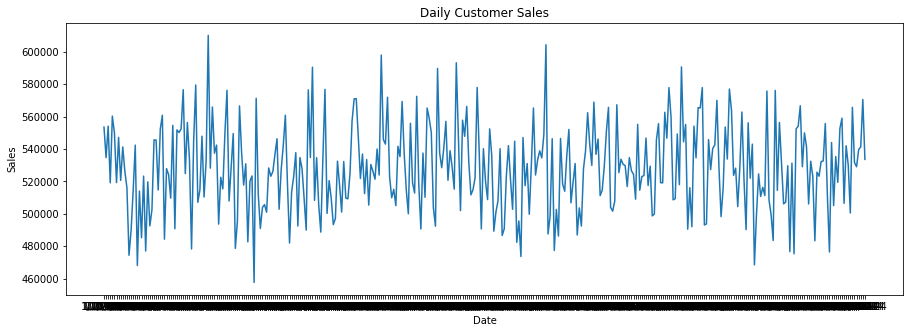

In [6]:
# check daily sales trend

salesDaily = sales.drop(['regions','channel','product'], axis = 1)
salesDaily = salesDaily.groupby(['date'], 
                      as_index = False)['sales'].sum().sort_values('date').reset_index(drop = True)


plt.figure(figsize = (15,5))
plt.plot(salesDaily['date'], salesDaily['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily Customer Sales')
plt.show()

In [7]:
# convert sales date field to datetime

sales['date'] = pd.to_datetime(sales['date'])

In [8]:
# Generalize Data values

salesPeriod = sales.copy()

salesPeriod['date'] = (salesPeriod['date'].dt.to_period("M")).dt.to_timestamp()
salesPeriod = salesPeriod.groupby(['regions', 'date','channel','product'], 
                      as_index = False)['sales'].sum().sort_values('date').reset_index(drop = True)

salesPeriod.head()

,regions,date,channel,product,sales
0,Africa,2024-01-01,Cloud,Certification,64891.0
1,Australia,2024-01-01,Direct,MIS,16403.0
2,Australia,2024-01-01,Direct,OTHERS,9178.0
3,Australia,2024-01-01,Direct,Support,15200.0
4,Australia,2024-01-01,Distributor,Certification,33875.0


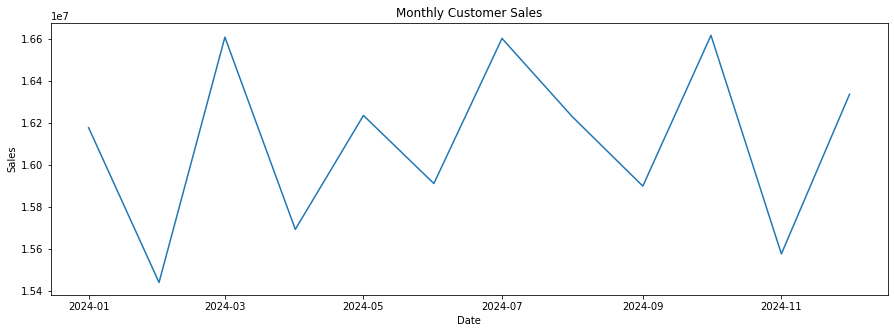

In [9]:
# monthly sales trend
monthStr = ('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December') 

salesMonthly = salesPeriod.drop(['regions','channel','product'], axis = 1)
salesMonthly = salesMonthly.groupby(['date'], 
                      as_index = False)['sales'].sum().sort_values('date').reset_index(drop = True)

plt.figure(figsize = (15,5))
plt.plot(salesMonthly['date'], salesMonthly['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales')
plt.show()

# Encoding features to values

In [10]:
#convert objects to 0/1

from sklearn.preprocessing import OrdinalEncoder

data_encoded = salesPeriod.copy()

obj_col = salesPeriod.columns[:4]

for i in obj_col:
    oe = OrdinalEncoder()
    data_encoded[i] = oe.fit_transform(data_encoded[[i]])
    exec("Arr_%s = np.array(oe.categories_[0]).tolist()" % (i))

data_encoded

,regions,date,channel,product,sales
0,0.0,0.0,0.0,0.0,64891.0
1,2.0,0.0,1.0,3.0,16403.0
2,2.0,0.0,1.0,5.0,9178.0
3,2.0,0.0,1.0,6.0,15200.0
4,2.0,0.0,2.0,0.0,33875.0
...,...,...,...,...,...
1268,1.0,11.0,1.0,5.0,69098.0
1269,1.0,11.0,1.0,4.0,110005.0
1270,1.0,11.0,1.0,3.0,39034.0
1271,2.0,11.0,1.0,1.0,9347.0


# Check Various ML Models

In [11]:
X =  data_encoded.drop(['sales'], axis = 1)
y =  data_encoded['sales']

In [12]:
# Devide data in training and testing datasets

X_train, X_test, y_train, y_test = X[:-100],X[-100:],y[:-100],y[-100:]

In [13]:
# checking performance of LinearRegression ML Model 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

LR = LinearRegression()
score = cross_val_score(LR,X,y,cv=5,scoring='r2')
print("Mean of cross validation Score for Linear Regression is : ", score.mean())

Mean of cross validation Score for Linear Regression is :  -3.062643371958274e-05


In [14]:
# checking performance of DecisionTreeClassifier ML Model 

from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(X_train,y_train)
pred_DT = DT.predict(X_test)

from sklearn.metrics import mean_absolute_error

MAE = mean_absolute_error(y_test, pred_DT)
print("Mean Absolute Error for Decision Tree Classifier is : ", MAE.mean())

Mean Absolute Error for Decision Tree Classifier is :  39747.37


In [15]:
# checking performance of RandomForestRegressor ML Model 

from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor(n_estimators=100)
score = cross_val_score(RF,X,y,cv=5,scoring='r2')
print("Mean of cross validation Score for Random Forest Regressor is : ", score.mean())

RF.fit(X_train,y_train)
pred_RF = RF.predict(X_test)
MAE = mean_absolute_error(y_test, pred_RF)
print("Mean Absolute Error for Random Forest Regressor is : ", MAE.mean())


Mean of cross validation Score for Random Forest Regressor is :  0.9138034059627185
Mean Absolute Error for Random Forest Regressor is :  34172.3116


In [16]:
# checking performance of xgboost ML Model 

from xgboost import XGBRFRegressor

XG = XGBRFRegressor(n_estimators=100)
score = cross_val_score(XG,X,y,cv=5,scoring='r2')
print("Mean of cross validation Score for XGBRFRegressor is : ", score.mean())



Mean of cross validation Score for XGBRFRegressor is :  0.8777465719064704


## Finalizing the model to go ahead with

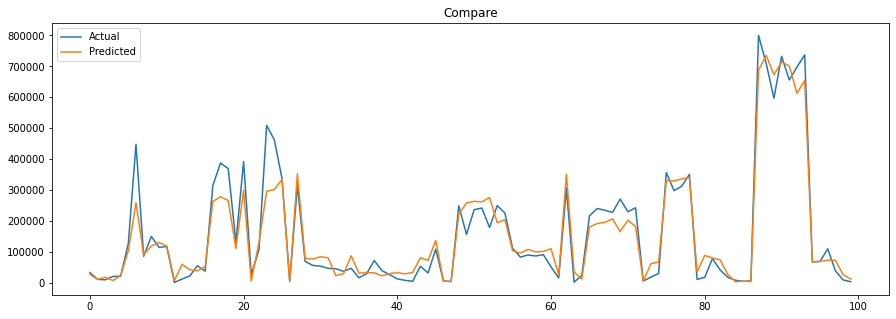

In [17]:
plt.figure(figsize = (15,5))
plt.plot(y_test.values, label = 'Actual')
plt.plot(pred_RF, label = 'Predicted')
plt.legend(loc="upper left")
plt.title('Compare')
plt.show()

# Model Implementation

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
RF.fit(X_train,y_train)
pred_RF = RF.predict(X_test)
MAE = mean_absolute_error(y_test, pred_RF)
print("Mean Absolute Error for Random Forest Regressor is : ", MAE)

Mean Absolute Error for Random Forest Regressor is :  23124.171098039216


## Define model outcome and perform prediction analysis

In [21]:
def prediction(regionidx, monthNo, channelidx, productidx):
    pred = RF.predict([[regionidx, monthNo, channelidx, productidx]])
    output = pred[0]
    
    prntdate = '2024-'+str(monthNo + 1)+'-01'
    actDf = salesPeriod[(salesPeriod.regions == Arr_regions[regionidx]) &
                        (salesPeriod.date == prntdate) &
                        (salesPeriod.channel == Arr_channel[channelidx]) &
                        (salesPeriod['product'] == Arr_product[productidx])].groupby(['regions','date','channel','product'])['sales'].sum()
    
    if not actDf.empty:
        act = actDf[0]
    else:
        act = 0
    
    graphDf = sales[(sales.regions == Arr_regions[regionidx]) &
                    (sales['date'].dt.month == monthNo + 1)  &
                    (sales.channel == Arr_channel[channelidx]) &
                    (sales['product'] == Arr_product[productidx])].groupby(['date'], as_index = False)['sales'].sum()
    
    graphDf['day'] =  (graphDf['date'].dt.day).astype(int)
    graphDf = graphDf.sort_values(['day']).reset_index(drop = True)
    graphDf = graphDf.drop(['day'], axis=1)
    for i in range(1,len(graphDf)):
        graphDf['sales'][i] += graphDf['sales'][i-1] 
    
    lastday = str(monthNo + 1)+'/' + str(calendar.monthrange(2024, monthNo + 1)[1] - 1) +'/2024'
    nxtyearData = [[lastday, max(0,round(output-MAE,2))],[lastday, round(output+MAE,2)]]
    dfNextyear = pd.DataFrame(nxtyearData, columns = ['date', 'sales'])
    dfNextyear['date'] = pd.to_datetime(dfNextyear['date'])
    
    plt.figure(figsize = (20,5))
    plt.plot(graphDf['date'], graphDf['sales'], label = 'Actuals')
    plt.plot(dfNextyear['date'], dfNextyear['sales'], label = 'Predicted')
    plt.legend(loc="upper left")
    plt.title('Compare')
    plt.show()
    

    print(f'''\n\n=================================================================================================================
    Total sale from \033[1m{Arr_channel[channelidx]}\033[0m channel partner for the month of \033[1m{monthStr[monthNo]}\033[0m for \033[1m{Arr_product[productidx]}\033[0m produt in \033[1m{Arr_regions[regionidx]}\033[0m region is \033[1mUSD {act}\033[0m
    Based on the Random Forest Regressor the sales for \033[1m{monthStr[monthNo]} 2025 \033[0m could be between \033[1m USD {str(max(0,round(output-MAE,2)))} to USD {str(round(output+MAE,2))}\033[0m''')
    

## Providing inputs to the model 


Select any value from ['Africa', 'Asia', 'Australia', 'Europe', 'North America', 'South America'] for region !!!


 Africa



Select any month from ('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December') only!!!


 February



Select any channel from ['Cloud', 'Direct', 'Distributor', 'OEM', 'Web'] only!!!


 Cloud



Select any product from ['Certification', 'Cloud Service', 'ERP', 'MIS', 'OS', 'OTHERS', 'Support'] only!!!


 Certification


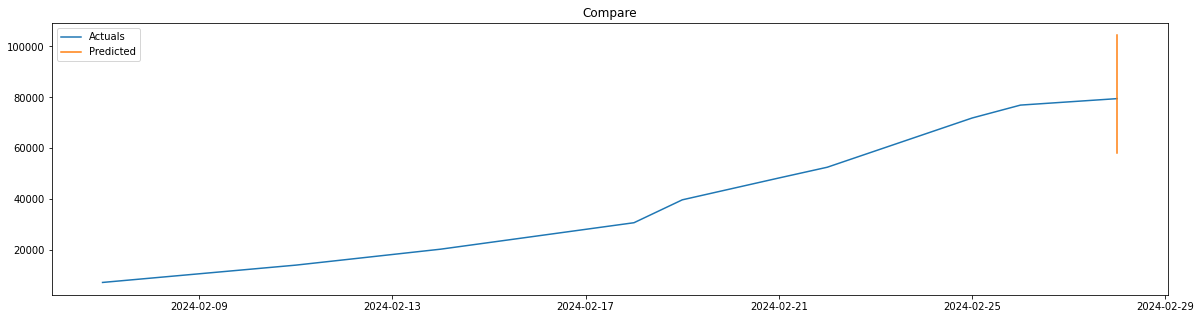



    Total sale from Cloud channel partner for the month of February for Certification produt in Africa region is USD 79478.0
    Based on the Random Forest Regressor the sales for February 2025  could be between  USD 58112.68 to USD 104361.02


In [22]:

print(f"\nSelect any value from {Arr_regions} for region !!!")
region = input()
regionidx = Arr_regions.index(region)

print(f"\nSelect any month from {monthStr} only!!!")
month = input()
monthNo = (datetime.datetime.strptime(month, '%B').month - 1)

print(f"\nSelect any channel from {Arr_channel} only!!!")
channel = input()
channelidx = Arr_channel.index(channel)

print(f"\nSelect any product from {Arr_product} only!!!")
product = input()
productidx = Arr_product.index(product)

prediction(regionidx,monthNo,channelidx,productidx)
